# ProofFlow Example

This notebook demonstrates the basic usage of ProofFlow for automated mathematical proof formalization.


In [1]:
import os

from dotenv import load_dotenv

from proofflow import LeanServer, LLMManager, ProofFlow

load_dotenv()

True

## Setup

First, we need to set up the Lean server and configure the LLM models. 

Please create a ".env" file containing API_KEY and OPEN_AI_BASE_URL


In [ ]:
# Set up Lean server (local or remote)
lean_server = LeanServer(api_url=os.getenv("LEAN_SERVER_URL"))  # Remote server
# OR
# lean_server = LeanServer(project_path="/path/to/mathlib")  # Local project

LeanServer initialized in LOCAL mode.


In [3]:
# Configure LLM models

#Graph building model and system prompt
graph_model = LLMManager(
    model_info={"api_key": os.getenv("API_KEY"), "base_url": os.getenv("OPEN_AI_BASE_URL"),
        "model": "google/gemini-2.5-pro",
    },
    system_prompt_path="prompts/proof_graph.md",
)

#Formalization model and system prompt
formalize_model = LLMManager(
    model_info={"api_key": os.getenv("API_KEY"),  "base_url": os.getenv("OPEN_AI_BASE_URL"),
        "model": "google/gemini-2.5-flash",
    },
    system_prompt_path="prompts/lemma_formalizer.md",
)

#Solver model and system prompt
solver_model = LLMManager(
    model_info={"api_key": os.getenv("API_KEY"), "base_url": os.getenv("OPEN_AI_BASE_URL"),
        "model": "deepseek/deepseek-prover-v2",
    },
    system_prompt_path="prompts/lemma_prover.md",
)

#Scoring model and system prompt (None)
score_model = LLMManager(
    model_info={"api_key": os.getenv("API_KEY"), "base_url": os.getenv("OPEN_AI_BASE_URL"),
        "model": "anthropic/claude-sonnet-4",
    },
    system_prompt_path=None,
)

## Initialize ProofFlow


In [4]:
# Initialize ProofFlow
proof_flow = ProofFlow(
    lean_server=lean_server,
    graph_model_manager=graph_model,
    formalize_model_manager=formalize_model,
    solver_model_manager=solver_model,
    score_model_manager=score_model,
    verbose=True,
)

## Process a Natural Language Proof


In [5]:
# Process a natural language proof
nl_proof = """
Theorem: For all real numbers x, y, if x² + y² = 1, then |x| ≤ 1.
Proof: Since x² ≥ 0 and y² ≥ 0, we have x² + y² ≥ x². 
Given that x² + y² = 1, we get 1 ≥ x², which means x² ≤ 1. 
Taking the square root of both sides, we obtain |x| ≤ 1.
"""

# Run formalization
proof_flow.autoformalize_series(nl_proof)



Building proof graph...

Proof graph completed (1 tries): 2 condition(s), 2 lemma(s), 1 theorem solution(s).
➤ Formalizing item 1/5: tc_1 ...
   ✔ Completed item tc_1.
➤ Formalizing item 2/5: tc_2 ...
   ✔ Completed item tc_2.
➤ Formalizing item 3/5: l1 ...
   ✔ Completed item l1.
➤ Formalizing item 4/5: l2 ...
   ✔ Completed item l2.
➤ Formalizing item 5/5: ts_1 ...
   ✔ Completed item ts_1.


## Get Results


In [6]:
# Get results
lean_code = proof_flow.get_lean_code()
print("Generated Lean 4 code:")
print(lean_code) 
#incorrectly formalized lemmas are not shown


Generated Lean 4 code:
import Mathlib
import Aesop
set_option maxHeartbeats 0
open BigOperators Real Nat Topology Rat Filter

lemma l1
  (x y : ℝ) :
  x^2 + y^2 ≥ x^2 := by
  have h : y^2 ≥ 0 := by exact sq_nonneg y
  linarith

lemma l2
  (x y : ℝ)
  (tc_2 : x^2 + y^2 = 1)
  (l1 : x^2 + y^2 ≥ x^2) :
  x^2 ≤ 1 := by
  rw [tc_2] at l1
  exact l1

lemma ts_1
  (x : ℝ)
  (l2 : x^2 ≤ 1) :
  |x| ≤ 1 := by
sorry


In [7]:
# Get performance summary
summary = proof_flow.summary()
print(f"Formalization accuracy: {summary['form_acc']:.2%}")
print(f"Proof success rate: {summary['solv_acc']:.2%}")


2 condition(s), 2 lemma(s), 1 theorem solution(s).
5 steps successfully formalized out of 5
2 steps successfully solved out of 3
Formalization accuracy: 100.00%
Proof success rate: 66.67%


## Generate Visualizations


c:\Users\r00922822\Downloads\latest_version_submission\proofflow\vis.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Static visualization saved as proof_dag.png


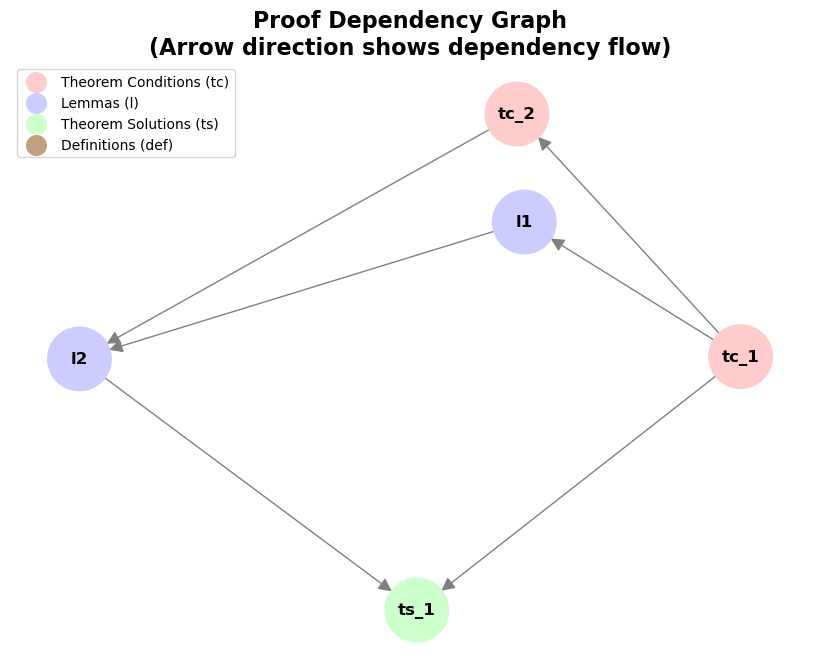

Interactive visualization saved as proof_dag.html
Visualizations saved as proof_dag.png and proof_dag.html


In [8]:
# Generate visualizations
proof_flow.plot_dag("proof_dag.png")
proof_flow.interactive_dag("proof_dag.html")
print("Visualizations saved as proof_dag.png and proof_dag.html")


## Advanced Features

### Semantic Scoring


In [9]:
# Compute proof scores
proof_flow.proof_score(verbose=True)
print(f"Total proof score: {proof_flow.total_score}")


➤ Checking score of step 1/5: tc_1 ...
   ✔ Score of step 1/5: tc_1 is 1.0
➤ Checking score of step 2/5: tc_2 ...
   ✔ Score of step 2/5: tc_2 is 1.0
➤ Checking score of step 3/5: l1 ...
   ✔ Score of step 3/5: l1 is 1.0
➤ Checking score of step 4/5: l2 ...
   ✔ Score of step 4/5: l2 is 1.0
➤ Checking score of step 5/5: ts_1 ...
   ✔ Score of step 5/5: ts_1 is 1.0
Total proof score: 1.0


### Error Analysis


In [10]:
# Perform comprehensive error analysis
proof_flow.error_analysis(score_threshold=0.6, prover_retries=3, verbose=True)

# Access error reports for each proof step
for item in proof_flow.proof_items:
    if hasattr(item, "error_report"):
        print(f"Step {item.id}: {item.error_report['error_type']}")

# Interactive DAG also shows error reports
proof_flow.interactive_dag("proof_dag.html")

➤ Checking errors in step 1/5: tc_1 …
   → None: Natural-language lemma and formalization appear consistent (lean_verify = True).
➤ Checking errors in step 2/5: tc_2 …
   → None: Natural-language lemma and formalization appear consistent (lean_verify = True).
➤ Checking errors in step 3/5: l1 …
   → None: Natural-language lemma and formalization appear consistent (lean_verify = True).
➤ Checking errors in step 4/5: l2 …
   → None: Natural-language lemma and formalization appear consistent (lean_verify = True).
➤ Checking errors in step 5/5: ts_1 …
   → Prover: Formalization appears correct (score=1.0 > 0.6), but the prover could neither prove the lemma nor its negation. This may be due to prover limitations, missing lemmas, or incomplete context.
Step tc_1: None
Step tc_2: None
Step l1: None
Step l2: None
Step ts_1: Prover
Interactive visualization saved as proof_dag.html
